# Mini Project 1

**2025 Introduction to Quantiative Methods in Finance**

**The Erdös Institute**

## Portfolio Optimization

(**Instructions** Use current stock data to create two potentially profitable investment portfolios. One that is higher risk and one that is lower risk.

-- You are to interpret and explain your interpretation of a high risk profile and low risk profile of a portfolio. You should provide some measurable quantitative data in your explanation.)

In [10]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
import datetime as dt
sns.set_style('darkgrid')

In order to create a stock portfolio, let us begin by scraping S&P 500 data off of wikipedia for the tickers.

In [11]:
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
sp500_df = pd.read_html(url, header=0)[0]

# Clean up DataFrame
sp500_df = sp500_df[['Symbol', 'Security', 'GICS Sector', 'GICS Sub-Industry']]
sp500_df.columns = ['Ticker', 'Company', 'Sector', 'Industry']


# Group by sector or industry
sector_groups = sp500_df.groupby('Sector')
industry_groups = sp500_df.groupby('Industry')

In [12]:
sp500_df['Sector'].value_counts()

Sector
Industrials               78
Financials                73
Information Technology    68
Health Care               60
Consumer Discretionary    51
Consumer Staples          38
Utilities                 31
Real Estate               31
Materials                 26
Communication Services    23
Energy                    23
Name: count, dtype: int64

I am trying to write a customizable portfolio optimizer. So here, we select 3 sectors at random and select a total of 20 stocks from the 4 sectors to work with.

In [13]:
chosen_sectors = np.random.choice(sp500_df['Sector'].unique(), size=4, replace=False)
print("Stocks will be chosen from: ", chosen_sectors)

Stocks will be chosen from:  ['Energy' 'Consumer Discretionary' 'Materials' 'Utilities']


In [18]:
ticker_list = np.array(sp500_df[sp500_df['Sector'].isin(chosen_sectors)]['Ticker'])
stock_tickers = np.random.choice(ticker_list, size=20, replace=False)
print('Chosen Stocks to be optimized in portfolio: ', stock_tickers)

Chosen Stocks to be optimized in portfolio:  ['BKR' 'TSCO' 'XEL' 'NVR' 'DOW' 'WMB' 'RL' 'LKQ' 'AZO' 'CNP' 'KMX' 'NI'
 'EOG' 'LNT' 'STLD' 'MAR' 'MGM' 'SBUX' 'VMC' 'ULTA']


I intend to include liquidity into consideration while optimizing the portfolio, hence I need to download both the stock price at closing and the volume traded.

In [17]:
data_download = yf.download(stock_tickers.tolist(), start="2024-06-01", end="2025-06-01", auto_adjust=False)
data_download.dropna(axis=1, inplace=True)  # Drop stocks with incomplete data

data = data_download['Close']
volume_data = data_download['Volume']

[*********************100%***********************]  10 of 10 completed

10 Failed downloads:
['ROST', 'WYNN', 'LOW', 'SHW', 'OXY', 'APTV', 'VMC', 'ULTA', 'MAR', 'XOM']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


In [294]:
avg_volume = volume_data.mean()
volume_data = avg_volume.values

Calculate daily returns and covariances

In [295]:
daily_returns = (data/data.shift(1)).dropna()  - 1
cov_matrix = daily_returns.cov()
mean_returns = daily_returns.mean()
annual_cov_matrix = cov_matrix * 252

Visualize covariance matrix

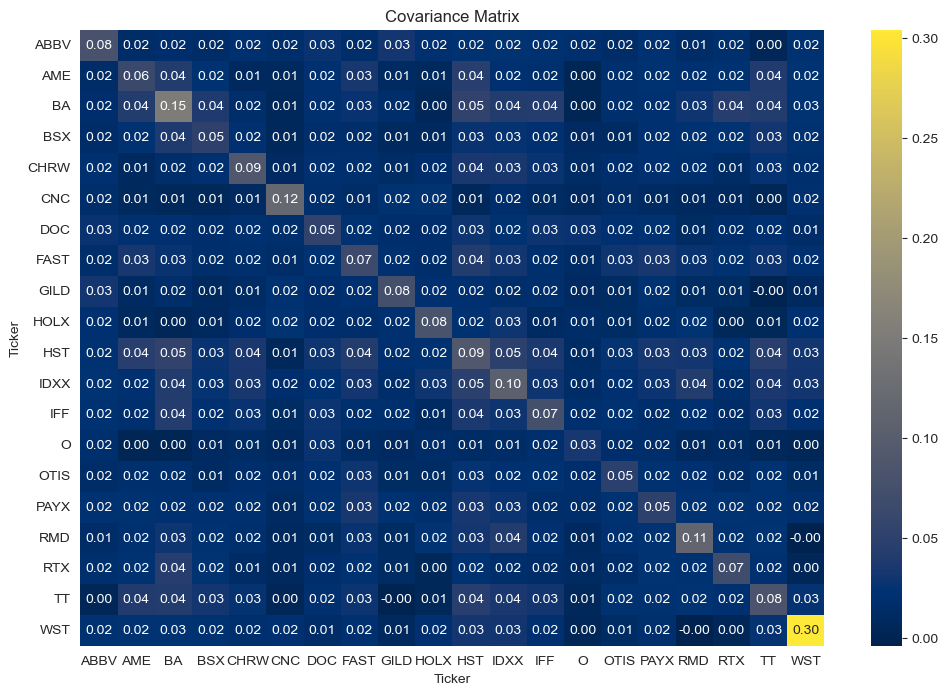

In [296]:
plt.figure(figsize = (12,8))
sns.heatmap(annual_cov_matrix, annot=True, cmap='cividis', fmt ='.2f')
plt.title('Covariance Matrix')
plt.show()

Consider a portfolio of stocks $\{S_1, S_2, ..., S_N\}$ with weights $\{w_1, w_2, ..., w_N\}$. The expected value of the portfolio is
$$
\mathbb{E}[P] = \sum_{i = 1}^N w_i\ \mathbb{E}[S_i]
$$

We can use the annualized average daily simple return for $\mathbb{E}[S_i]$. The variance of the portfolio is given by

$$
\sigma^2[P] = \sum_{i,j} w_i\text{Cov}(S_i, S_j) w_j = w^T\cdot \Sigma \cdot w
$$
where $\Sigma$ is the covariance matrix and $\cdot$ indicates matrix multiplication.

Finally, assume that the average traded volume of stock $S_i$ is $V_i$. Low $V_i$ implies low liquidity, which means that you cannot sell much stock without changing its price in the market. We want to punish low liquidity. 

Thus, we obtain the _liquidity aware objective function_ with a free parameter $\lambda$,
$$
    \mathcal{O}[w] = w^T\cdot\Sigma\cdot w + \lambda\left(\frac{w^T\cdot w}{V}\right)
$$

In what follows, we construct this objective function given a set of stocks and minimize it using scipy.optimize


In [297]:
n_assets = len(mean_returns)

def liquidity_aware_objective(weights, cov_matrix, volume_vector, lambd):
    portfolio_variance = weights.T @ cov_matrix @ weights
    liquidity_penalty = np.sum(weights**2 / volume_vector)
    return portfolio_variance + lambd * liquidity_penalty

def get_constraints(mu, target_return):
    constraints = (
        {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},  # Fully invested
        {'type': 'ineq', 'fun': lambda weights: weights @ mu - target_return}, # Return constraint
        )
    return constraints

Calculate efficient frontier:

Efficient Frontier is a set of portfolios that satisfy the condition that no other portfolio exists with a higher expected return but with the same standard deviation of return (i.e., the risk).

In [298]:
mu = mean_returns
cov = annual_cov_matrix
volume_vector = volume_data
n_points = 100
lambd = 0

target_returns = np.linspace(mu.min(), mu.max(), n_points)

risks = []
returns = []
weights_list = []

# Define an initial guess for asset weights (e.g., equal weights)
initial_weights = np.array([1/n_assets] * n_assets)


for target in target_returns:
    constraints = get_constraints(mu, target)
    x0 = initial_weights  # Initial guess

    result = minimize(
        liquidity_aware_objective, x0,
        args=(cov, volume_vector, lambd),
        method='SLSQP',
        constraints=constraints,
        bounds = [(0.001, 1.0)] * n_assets
    )
    if result.success:
        optimal_weights = result.x
        portfolio_return = optimal_weights @ mu
        portfolio_risk = np.sqrt(optimal_weights.T @ cov @ optimal_weights)
        returns.append(portfolio_return)
        risks.append(portfolio_risk)
        weights_list.append(optimal_weights)
    else:
        print("Optimization failed at return:", target)

c:\Users\jaych\anaconda3\lib\site-packages\scipy\optimize\_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Optimization failed at return: 0.002484829961257251
Optimization failed at return: 0.0025211126463168653


Plot the efficient frontier:

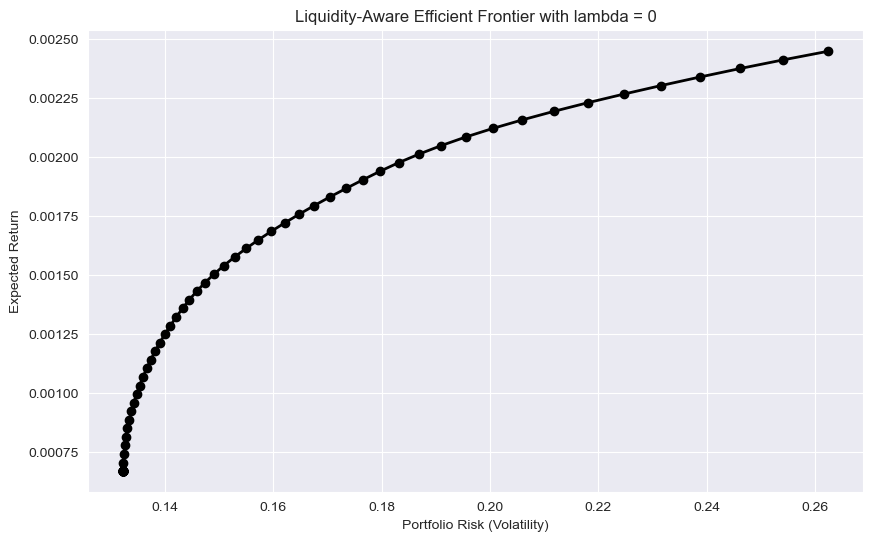

In [299]:
plt.figure(figsize=(10, 6))
plt.plot(risks, returns, '-o', linewidth=2, color='black')
plt.xlabel('Portfolio Risk (Volatility)')
plt.ylabel('Expected Return')
plt.title("Liquidity-Aware Efficient Frontier with lambda = "+str(lambd))
plt.grid(True)
plt.show()

Enclose the above code in a function so that we can run it for different lambdas:

In [ ]:
def get_efficient_frontier(mu, cov, volume_vector, lambd, n_points):
    n_assets = len(mu)
    target_returns = np.linspace(mu.min(), mu.max(), n_points)

    risks = []
    returns = []
    weights_list = []

    initial_weights = np.array([1/n_assets] * n_assets)


    for target in target_returns:
        constraints = get_constraints(mu, target)
        x0 = initial_weights  # Initial guess

        result = minimize(
            liquidity_aware_objective, x0,
            args=(cov, volume_vector, lambd),
            method='SLSQP',
            constraints=constraints,
            bounds = [(0.001, 1.0)] * n_assets
        )
        if result.success:
            optimal_weights = result.x
            portfolio_return = optimal_weights @ mu
            portfolio_risk = np.sqrt(optimal_weights.T @ cov @ optimal_weights)
            returns.append(portfolio_return)
            risks.append(portfolio_risk)
            weights_list.append(optimal_weights)
        else:
            print("Optimization failed at return:", target)

    return weights_list, returns, risks

Optimization failed at return: 0.0025211126463168653
Optimization failed at return: 0.0025211126463168653
Optimization failed at return: 0.0025211126463168653
Optimization failed at return: 0.0025211126463168653
Optimization failed at return: 0.0025211126463168653


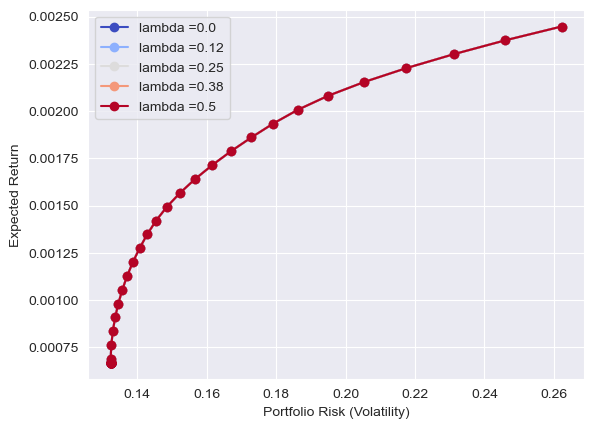

In [301]:
n_lambdas = 5
lambd_array = np.linspace(0, 0.5, n_lambdas)
# Colormap for plots
cmap = plt.cm.coolwarm 
colors = [cmap(i / (n_lambdas - 1)) for i in range(n_lambdas)]

for i in range(n_lambdas):
    opt_weights, returns, risks = get_efficient_frontier(mu, cov, volume_vector, lambd_array[i], n_points = 50)
    plt.plot(risks, returns, '-o', color=colors[i], label='lambda ='+str(round(lambd_array[i],2)))
    
plt.xlabel('Portfolio Risk (Volatility)')
plt.ylabel('Expected Return')
plt.grid(True)
plt.legend()
plt.show()

Seems like the liquidity constraint is not moving the efficient frontier at all, we can work with $\lambda = 0$.

Finally, let us generate sample portfolios on the efficient frontier with high and low risks. 

In [302]:
opt_weights, returns, risks = get_efficient_frontier(mu, cov, volume_vector, lambd = 0, n_points = 100)

Optimization failed at return: 0.002484829961257251
Optimization failed at return: 0.0025211126463168653


In [303]:
min_risk_index = risks.index(min(risks))
high_risk_index = len(risks)-10

In [304]:
high_risk_portfolio = opt_weights[high_risk_index]


print("A High-Risk Portfolio on the Efficient Frontier")
for i in range(n_assets):
    if round(high_risk_portfolio[i], 5) > 0:
        print(stock_tickers[i], round(high_risk_portfolio[i], 4))  

print('Annualized Volatility = ', round(risks[high_risk_index]*100, 2), "%")
print('Average Daily Return (Simple) = ', round(returns[high_risk_index]*100, 2), "%")

A High-Risk Portfolio on the Efficient Frontier
WST 0.001
TT 0.001
DOC 0.001
RMD 0.1722
GILD 0.001
CNC 0.001
HOLX 0.001
O 0.001
PAYX 0.6572
FAST 0.001
AME 0.001
OTIS 0.001
IFF 0.001
IDXX 0.001
HST 0.001
BSX 0.001
ABBV 0.001
RTX 0.001
CHRW 0.1536
BA 0.001
Annualized Volatility =  20.05 %
Average Daily Return (Simple) =  0.21 %


In [305]:
low_risk_portfolio = opt_weights[min_risk_index]
print("A Low-Risk Portfolio on the Efficient Frontier")
for i in range(n_assets):
    if round(low_risk_portfolio[i], 4) > 0:
        print(stock_tickers[i], round(low_risk_portfolio[i], 4))

print('Annualized Volatility = ', round(risks[min_risk_index]*100, 2), "%")
print('Average Daily Return (Simple) = ', round(returns[min_risk_index]*100, 2), "%")

A Low-Risk Portfolio on the Efficient Frontier
WST 0.001
TT 0.1254
DOC 0.001
RMD 0.098
GILD 0.0436
CNC 0.0626
HOLX 0.001
O 0.001
PAYX 0.0907
FAST 0.0531
AME 0.001
OTIS 0.001
IFF 0.001
IDXX 0.3434
HST 0.0482
BSX 0.001
ABBV 0.0283
RTX 0.0566
CHRW 0.0246
BA 0.0173
Annualized Volatility =  13.23 %
Average Daily Return (Simple) =  0.07 %
